# Time series forecasting with python
This repository tries to encapsulate the basics of time series forecasting. I will talk through the basics of time series analysis and give an overview of the most efective methods I have encountered for both Univariate and Multivariate series.






**Why this repository?**

A lof of github repositories for time series forecasting use dummy series with strong and unrealistic features to showcase different models. This repository tries to give a more real use scenario on how to approach time series forecasting.

In [1]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from utils.metrics import evaluate
from utils.plots import bar_metrics


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Importing plotly failed. Interactive plots will not work.


2.4.0


# 📚 Time series analysis and transforms

This notebook contains a set of operations we can perform in our time series in order to get some insights or transform the series to make forecasting easier.

Which ones will we touching in this notebook?

* Time series decomposition
  * Level
  * Trend
  * Seasonality
  * Noise

* Stationarity
  * AC and PAC plots
  * Rolling mean and std
  * Dickey-Fuller test

* Making our time series stationary
  * Difference transform
  * Log scale
  * Smoothing
  * Moving average

## Load the dataset and quick preview

In [2]:
air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

pollution_today        dew       temp        press     wnd_spd  \
date                                                                         
2010-01-02       145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03        78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04        31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05        42.458333 -24.583333 -14.458333  1033.625000   56.920000   
2010-01-06        56.416667 -23.708333 -12.541667  1033.750000   18.511667   

                 snow  rain  pollution_yesterday  
date                                              
2010-01-02   0.708333   0.0            10.041667  
2010-01-03  14.166667   0.0           145.958333  
2010-01-04   0.000000   0.0            78.833333  
2010-01-05   0.000000   0.0            31.333333  
2010-01-06   0.000000   0.0            42.458333

In [3]:
air_pollution.describe()

pollution_today          dew         temp        press      wnd_spd  \
count      1825.000000  1825.000000  1825.000000  1825.000000  1825.000000   
mean         98.245080     1.828516    12.459041  1016.447306    23.894307   
std          76.807697    14.163508    11.552997    10.076053    41.373161   
min           3.166667   -33.333333   -14.458333   994.041667     1.412500   
25%          42.333333   -10.083333     1.541667  1007.916667     5.904167   
50%          79.166667     2.041667    13.916667  1016.208333    10.953750   
75%         131.166667    15.083333    23.166667  1024.541667    22.235000   
max         541.895833    26.208333    32.875000  1043.458333   463.187917   

              snow         rain  pollution_yesterday  
count  1825.000000  1825.000000          1825.000000  
mean      0.052763     0.195023            98.245080  
std       0.546072     0.993917            76.807697  
min       0.000000     0.000000             3.166667  
25%       0.000000     0.000000            42.333333  
50%       0.000000     0.000000            79.166667  
75%       0.000000     0.000000           131.166667  
max      14.166667    17.583333           541.895833

## Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time

##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model.

##### Automatic time series decomposition

Statsmodel python library provides a function [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the pm2.5 time series shows no linear trend.

### Level

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

### Trend

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. We will see different methods for this in the making your series stationary section

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it,
Create line plots of your data and inspect the plots for obvious trends.

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend



### Seasonality
Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. 

### Noise

Our time series will also have a noise component to them, most likely [white noise](https://en.wikipedia.org/wiki/White_noise). We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?
* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
* Correlation plots
* Standard deviation distribution, is it a Gaussian distribution?
* Does the mean or level change over time?

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity




### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.



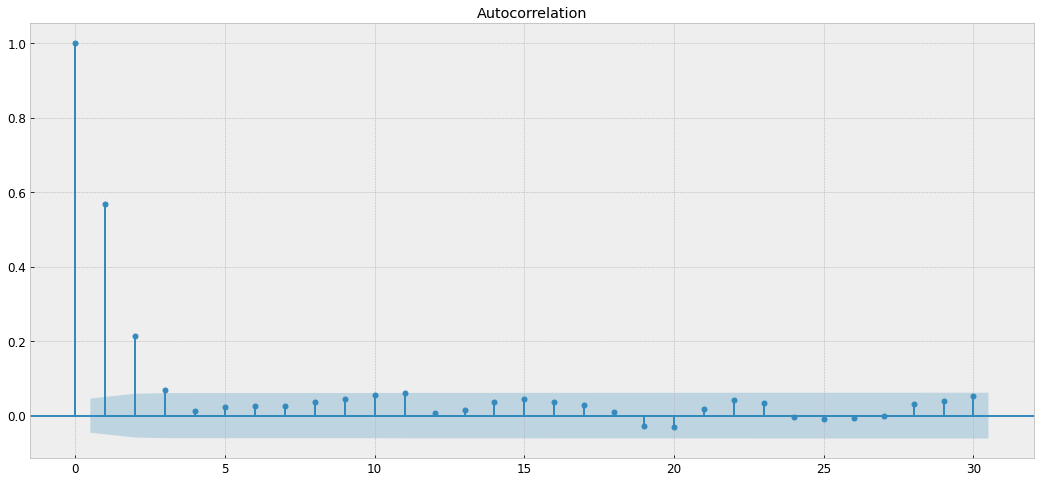

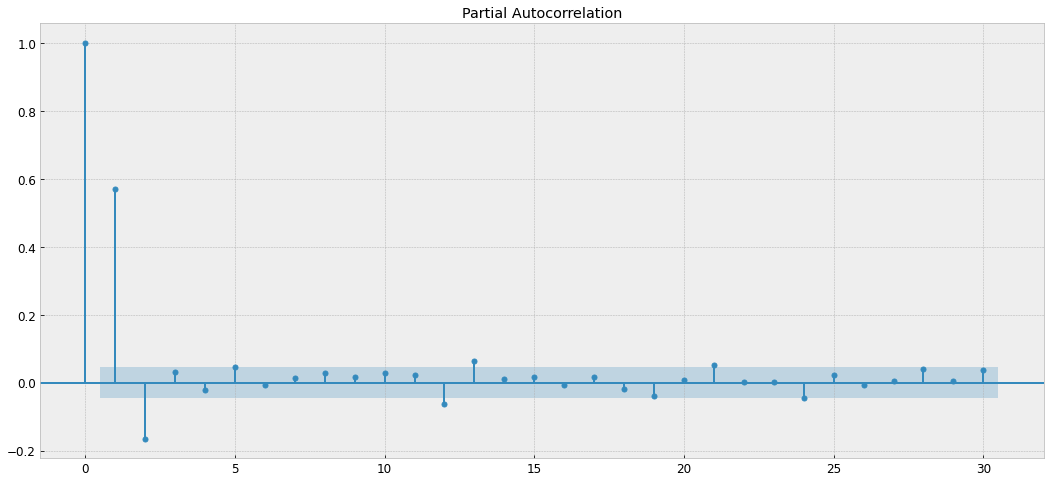

In [13]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Rolling means and standard deviation of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

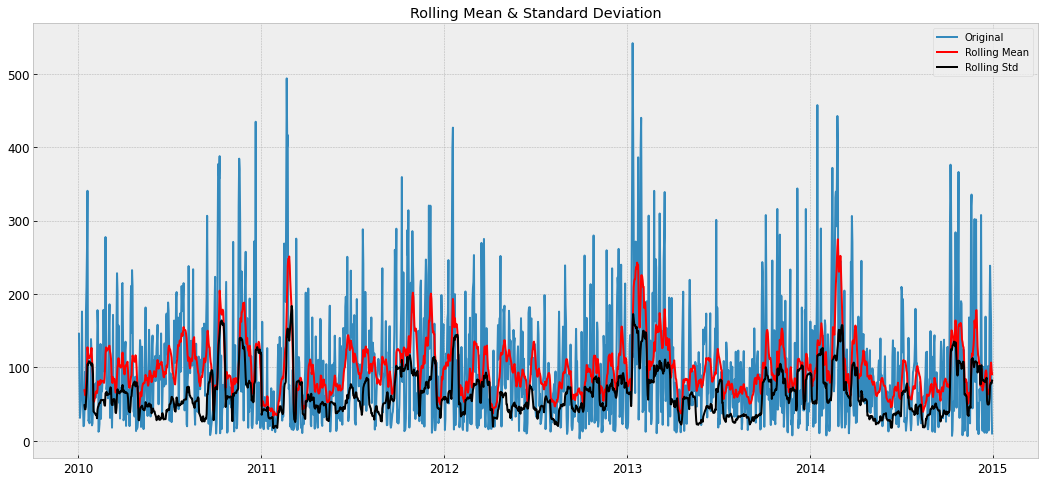

In [14]:
# Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.
- If the p-value from the test is greater  than some significance level (e.g. α = .05), then fail reject the null hypothesis and conclude that the time series is non stationary.

Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.


We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

### What is the P-value?
The p-value, or probability value, is a statistical measure used in hypothesis testing to assess the strength of evidence against a null hypothesis. 
- It represents the probability of obtaining results as extreme as, or more extreme than, the observed results under the assumption that the null hypothesis is true.
- In simpler words, it is used to reject or support the null hypothesis during hypothesis testing. In data science, it gives valuable insights on the statistical significance of an independent variable in predicting the dependent variable.

### How P-value is calculated?
- Calculating the p-value typically involves the following steps:

- Formulate the Null Hypothesis (H0): Clearly state the null hypothesis, which typically states that there is no significant relationship or effect between the variables.
- Choose an Alternative Hypothesis (H1): Define the alternative hypothesis, which proposes the existence of a significant relationship or effect between the variables.
- Calculate the Critical-value: Based on the observed test statistic and the sampling distribution, find the probability of obtaining the observed test statistic or a more extreme one, assuming the null hypothesis is true.
- Interpret the results: Compare the critical-value with t-statistic. If the t-statistic is larger than the critical value, it provides evidence to reject the null hypothesis, and vice-versa.

In [15]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF statistic is higher than any of the critical values.

## Making Time Series Stationary

Okay we got lucky with this dataset and is already stationary, but what happens when this is not the case? We included a dummy dataset called `international_airline_passengers.csv` on the datasets folders which is not stationary and we will apply some methods in this section to transform it into a stationary series.

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

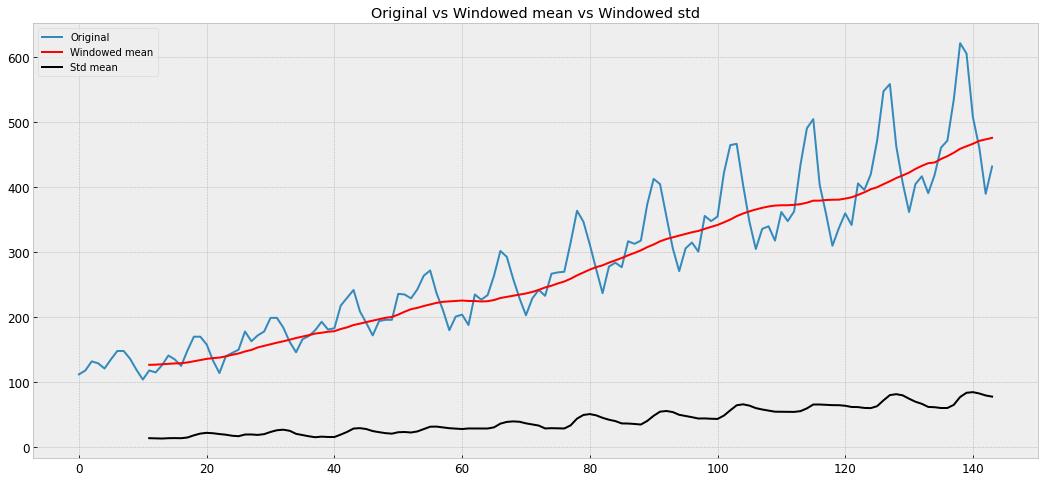

In [17]:
passengers = pd.read_csv("datasets/international_airline_passengers.csv")
passengers.passengers.plot(label='Original')
passengers.passengers.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')
passengers.passengers.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

### Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 difference it looks closer to a stationary series

### Log scale transformation

Applying a log scale transform to a time series could also  help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`LogScaleTransform(t)= Log(t)`

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.



**Prepare data before modeling**

In [25]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [26]:
# Also add the naive mean average value
mean = df_training.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['Yesterdays value'] = df_test.pollution_yesterday.values

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [27]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 364/364 [00:05<00:00, 70.14it/s]


### Holt Winter’s Exponential Smoothing (HWES)

[HWES](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) or also known as triple exponential smoothing

- Simple Exponential Smoothing (SES): Simple exponential smoothing assumes that the time series has no change in level. Thus, it can not be used with series that contain trend, seasonality, or both.
- Holt’s Exponential Smoothing (HES): Holt’s exponential smoothing is one step above simple exponential smoothing, as it allows the time series data to have a trend component. Holt’s exponential smoothing is still incapable of cope with seasonal data.
- Winter’s Exponential Smoothing (WES): Winter’s exponential smoothing is an extension to Holt’s exponential smoothing that finally allows for the inclusion of seasonality. Winter’s exponential smoothing is what is referred to as the Holt-Winters method.

In [28]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 364/364 [00:05<00:00, 72.20it/s]


### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


In [29]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = AR(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 364/364 [00:02<00:00, 179.80it/s]


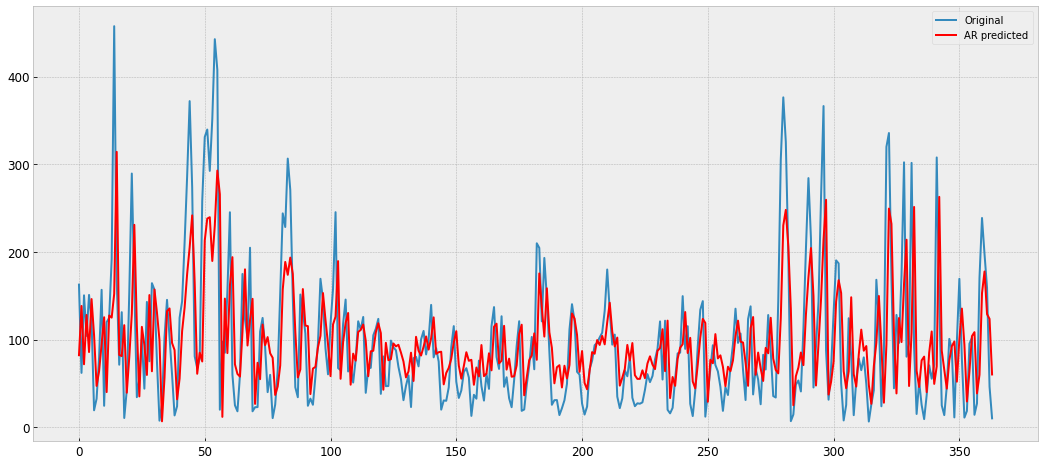

In [30]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

### Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



In [31]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 364/364 [00:16<00:00, 22.49it/s]


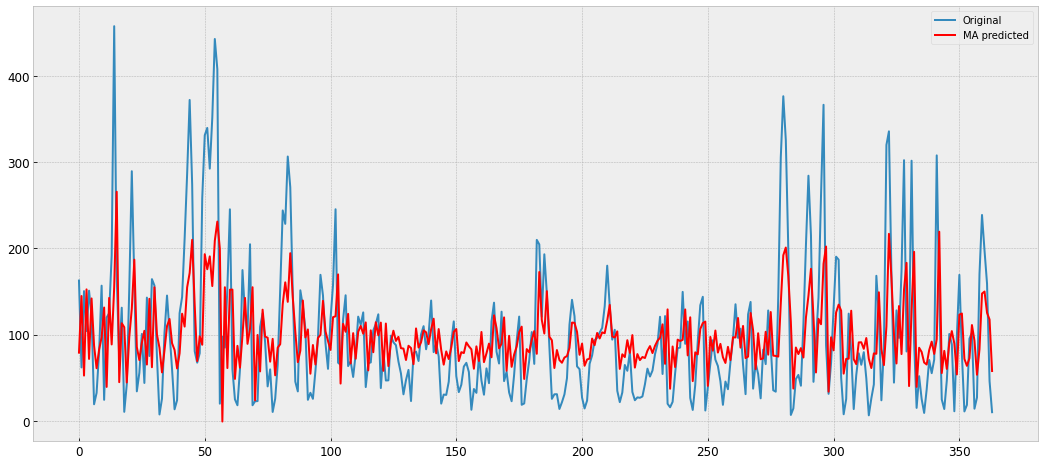

In [32]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



In [33]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 364/364 [01:00<00:00,  5.97it/s]


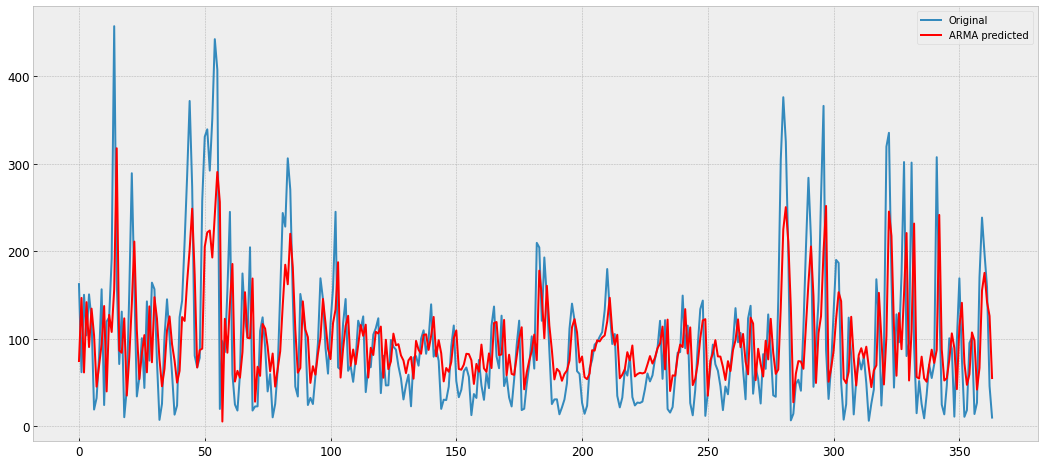

In [34]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [35]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:16<00:00, 21.61it/s]


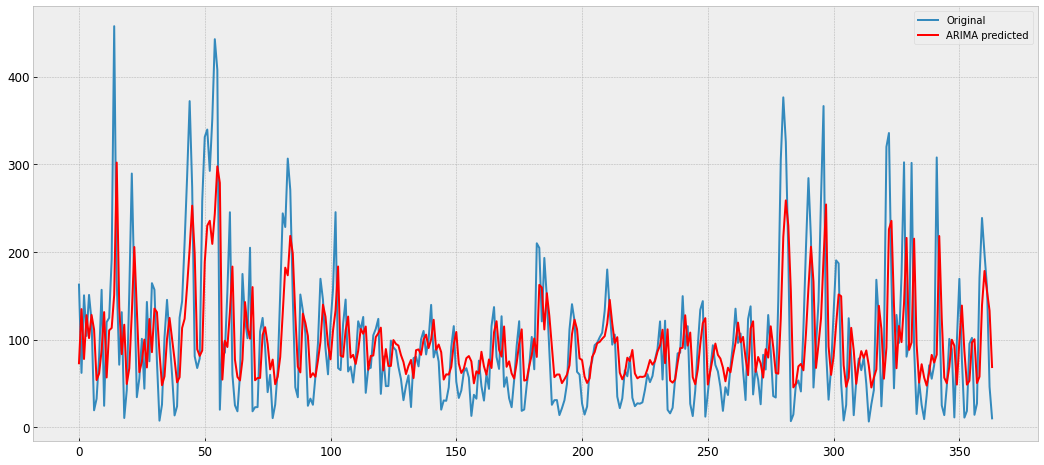

In [36]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [62]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [63]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/5
200/200 [==============================] - 8s 29ms/step - loss: 60.6344 - val_loss: 44.8015
Epoch 2/5
200/200 [==============================] - 4s 22ms/step - loss: 38.2016 - val_loss: 35.9713
Epoch 3/5
200/200 [==============================] - 5s 27ms/step - loss: 31.5666 - val_loss: 30.9032
Epoch 4/5
200/200 [==============================] - 4s 21ms/step - loss: 27.9560 - val_loss: 33.0068
Epoch 5/5
200/200 [==============================] - 3s 16ms/step - loss: 25.6375 - val_loss: 30.3579


In [65]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

#### DeepAR

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon

In [66]:
features = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
            'pollution_yesterday', 'hour', 'dayofweek', 'quarter', 'month',
            'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler()
scaler.fit(X_train)  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.pollution_today,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.pollution_today,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [67]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 25884
100%|██████████| 50/50 [00:03<00:00, 12.76it/s, epoch=1/5, avg_epoch_loss=5.71]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.921 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.708307
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.01it/s, epoch=2/5, avg_epoch_loss=5.54]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.571 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=5.543001
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.97it/s, epoch=3/5, avg_epoch_loss=5.45]
INFO:gluonts.trainer:Epoch[2] Elapsed time 4.177 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=5.451950
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.40it/s, epoch=4/5, avg_epoch_loss=5.34]
INFO:gluonts.trainer:Epoch[3] Elapsed time 3.732 seconds
INFO:gluo

In [68]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat